In [29]:
#imports
using Distributions;
using Random;
using DataFrames;
using Trapz; #for normalisation
using Statistics;
using LinearAlgebra;
using Plots;
using Interpolations;
using ZChop;
using ForwardDiff;
using CSV;
using ImageFiltering; #convolution
using ForwardDiff;
using DifferentialEquations;
using StatsBase;



In [30]:
###global parameters
global samples = 5000
global Tf = 5 #end time
global T_0 = 0 #start time

#parameters
global uref1 = 0.0 #reference potential =0
global uref2 = 0.0

global tau = 1
global L = 1;
global m = 1; #mass
global g = 0;
global omega = 1

##constant variables for the eqs
#global B = -(tanh(T_f/2)/T_f)*(((1-exp(-T_f))^2)/(1+4*exp(-T_f)+exp(-2*T_f)))
#global A = -(- 1 + 2*(tanh(T_f/2)/T_f) - B)

global A = (1+g)*(1 - (((omega^2 - 4)*(tanh(omega*Tf/2)*tanh(Tf)))/(omega*Tf*(omega*tanh(omega*Tf/2)-2*tanh(Tf)))))
global B = -((1+g)/Tf)*tanh(omega*Tf/2)*(omega*tanh(Tf) - 2*tanh(omega*Tf/2))/(omega*tanh(omega*Tf/2) - 2*tanh(Tf))
global alpha = sqrt(A)

global epsilon = 0.2  #0.5 #tau / sqrt(m * beta * (L^2) );
global sf = epsilon^2;
global T = round(sf*Tf,digits= 2)  #final value of t2

t = LinRange(0,T,samples);

global beta = 1 #inverse temp
global mu = 1

#global h = 0.001 #timestep

#plotting 
#space to use for estimation 
#use these to take weighted samples for x_0
global interval_start = -6
global interval_end = 6
x_axis = Array(range(interval_start,interval_end,samples));
x_init = Array(transpose(x_axis))

global max_iters = 1 #max iterations of recursion
global max_iters_prox = 1 #max iterations of proximal solver

global times =  [0, T/4, T/2, T]; #times to be plotted plots
global num_plots = length(times)

global zeros_tol = Float16(0.0000000000001) #cut off to zero to improve stability.  

psi(u) = 0
d_psi(u) = 0

function normalisation(y)
    
    return replace(y ./ abs(trapz(vec(x_axis),vec(abs.(y)))),NaN=>0)
end

function interpolation(from_x,phi)
    
    extra_ = linear_interpolation(Array(from_x), vec(phi),extrapolation_bc = 0) 
    return extra_(vec(x_axis))    
end;

function interpolation_hat(from_x,phi)
    
    extra_ = linear_interpolation(Array(from_x), vec(phi), extrapolation_bc = 0) 
    return extra_(vec(x_axis))    
end;


###########
#initial state
initial_fun(y) = exp.(-(y .-1).^4) #exp.(-(((y.^2).-1).^2) ./ 2);

#final state
final_fun(y) =  exp.(-(y.^2 .- 1 .^2).^2)

# = (normalisation((initial_fun(x_axis))))
#rho_1_vals = (normalisation((final_fun(x_axis)))); # Distributions.pdf.(Normal(1,sqrt(1/12)),x_init)#

rho_0_vals = Array(transpose(normalisation(initial_fun(x_axis))))
rho_1_vals = Array(transpose(normalisation(final_fun(x_axis)))); # 


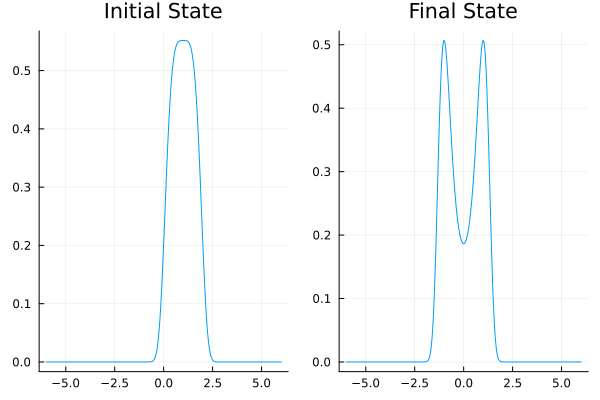

In [31]:

plot([x_axis,x_axis],[vec(rho_0_vals),vec(rho_1_vals)],
            layout= 2,
            #xlim = [(-5,5) (-5,5)],
            legend = false,
            titles = ["Initial State" "Final State"])


In [32]:
##MONTE CARLO METHOD 
####EM Scheme
function x_evolution(y::Array, N, time,d_psi) 
    #y= input vector;N=number of timesteps in discretisation
    y_end = copy(y)
    time_delta = time/N
    for _ in 1:N
        #take appropriate samples from normal 
        y_end = y_end .+ sqrt(2*time_delta*alpha) .* rand(Normal(0,1),(1,samples)) #.+ (d_psi(y_end).*time_delta) 
    end
  return sort(y_end,dims=1)
end; 

#use to solve a pde using monte carlo method
function mc_solver(phi,y,N,M,time,start_time,d_psi)
    #phi=function,y=initial points, M=number samples for MC
    sum_x = zeros(size(y))#zeros((samples,1)) 
    for _ in 1:M
        y_end = x_evolution(y,N,time,d_psi)# vec(x_evolution(y,N,time))
        sum_x .+= phi(start_time,y_end)
    end
    return sum_x./M
end;


In [33]:
##filtering functions

function filtering(input_array,filter_delta)
    
    #= this function implements a simple box filter of size filter_delta and padds missing reults
    
    inputs: 
    input_array - array to be smooths
    filter_delta - size of filter, number of nearest neighbours to consider
    
    output:
    filtered array with borders filled with constant value. 
    =#
    
    return imfilter(vec(input_array),reflect((1/filter_delta).*centered(ones(filter_delta))),Pad(:replicate)) 
end;


function interpolation_mc(x,phi) #method to create an interpolated function from x_axis
    
    extra_ = linear_interpolation(Array(x_axis), vec(phi), extrapolation_bc = Line()) 
    return Array(transpose(extra_(vec(x))))
    
end;


In [34]:
max_iters = 15 #maximum iterations for recursion
M = 50000
iters_sb = 1
h = 0.005

#initialise vars
phi_hat_1 = ones(1,samples) #everywhere positive (random numbers)\
phi_hat_0 = ones(1,samples)
phi_1 = ones(1,samples)
phi_0 = ones(1,samples)
p_0 = ones(1,samples)
p_1 = ones(1,samples)

N = Int(floor(T/h)) #number of time steps
num_steps = Int(N + 1) #indexing var

#error_iter = 1
errors_diff_prox = zeros(max_iters,4)

while iters_sb <= max_iters

    #store old vars
    phi_1_old = phi_1
    phi_0_old = phi_0
    phi_hat_1_old = phi_hat_1
    phi_hat_0_old = phi_hat_0
   
    #compute new 
    phi_1 = replace!(zchop(rho_1_vals./phi_hat_1) ,Inf=>0,NaN =>0)#,zeros_tol)
    
    phi_1_fun(t,x) = interpolation_mc(x,phi_1)

    phi_0 = replace!(normalisation(mc_solver(phi_1_fun,x_init,N,M,T,1,d_psi)), Inf=>0)

    phi_hat_0 = replace!(zchop((rho_0_vals ./ phi_0),zeros_tol), Inf=>0)
    phi_hat_0_fun(t,x) = interpolation_mc(x,phi_hat_0)
    phi_hat_1 = replace!(normalisation(mc_solver(phi_hat_0_fun,x_init,N,M,T,0,d_psi)), Inf=>0)    
        
    #compute l2 diffs
    errors_diff_prox[iters_sb,1] = sum((abs.(phi_1_old .- phi_1)).^2)/samples
    errors_diff_prox[iters_sb,2] = sum((abs.(phi_0_old .- phi_0)).^2)/samples
    errors_diff_prox[iters_sb,3] = sum((abs.(phi_hat_1_old .- phi_hat_1)).^2)/samples
    errors_diff_prox[iters_sb,4] = sum((abs.(phi_hat_0_old .- phi_hat_0)).^2)/samples
    
    println(iters_sb)
    iters_sb += 1

end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


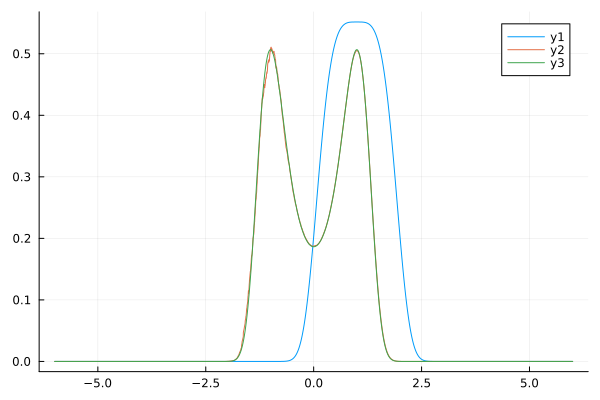

In [35]:
plot(x_axis,normalisation(vec(phi_0 .* phi_hat_0)))
plot!(x_axis,filtering(normalisation(vec(phi_1 .* phi_hat_1)),50))
plot!(x_axis,normalisation(vec(rho_1_vals)))


In [36]:
#M = 10000

len_times = N
time_interval = Array(0:len_times) ./len_times

filter_delta = 64

num_time_steps = length(time_interval)

time_step = h #0.005 #1/len_times

plot_pdfs_mc = zeros((samples,num_time_steps))
plot_phis_mc = zeros((samples,num_time_steps))
plot_phi_hats_mc = zeros((samples,num_time_steps))

plot_phis_mc[:,1] = zchop(normalisation(filtering(phi_0,filter_delta)))
#zchop(normalisation(imfilter(vec(phi_0),reflect(centered(kernel)),Fill(0))),0.00001)
plot_phi_hats_mc[:,1] = zchop(normalisation(filtering(phi_hat_0,filter_delta)))
#normalisation(imfilter(vec(phi_hat_0),reflect(centered(kernel)),Fill(0)))
plot_phis_mc[:,end] = zchop(normalisation(filtering(phi_1,filter_delta)))
#zchop(normalisation(imfilter(vec(phi_1),reflect(centered(kernel)),Fill(0))),0.00001)
plot_phi_hats_mc[:,end] = zchop(normalisation(filtering(phi_hat_1,filter_delta)))
#normalisation(imfilter(vec(phi_hat_1_mc),reflect(centered(kernel)),Fill(0)))

plot_pdfs_mc[:,1] = normalisation(plot_phis_mc[:,1] .* plot_phi_hats_mc[:,1])
plot_pdfs_mc[:,end] = normalisation(plot_phis_mc[:,end] .* plot_phi_hats_mc[:,end])

phi_1_fun(t,x) = interpolation_mc(x,phi_1)
phi_hat_0_fun(t,x) = interpolation_mc(x,phi_hat_0)

phi_fun_temp2(t,x) = phi_1_fun(t,x)
phi_hat_fun_temp2(t,x) = phi_hat_0_fun(t,x)

for i in 1:num_time_steps-2
    
    phi_temp_mc = vec(replace!(normalisation(mc_solver(phi_fun_temp2,x_init,1,M,time_step,1,d_psi)), Inf=>0))
    plot_phis_mc[:,num_time_steps - i] = zchop(normalisation(filtering(phi_temp_mc,filter_delta)))
    #zchop(normalisation(imfilter(phi_temp_mc,reflect(centered(kernel)),Fill(0))),0.00001)

    phi_fun_temp2(t,x) = interpolation_mc(x,phi_temp_mc)
    
end

for i in 1:num_time_steps-2
    
    phi_hat_temp_mc = vec(replace!(normalisation(mc_solver(phi_hat_fun_temp2,x_init,1,M,time_step,0,d_psi)), Inf=>0))
    
    phi_hat_fun_temp2(t,x) = interpolation_mc(x,phi_hat_temp_mc)
    
    plot_phi_hats_mc[:,i+1] = normalisation(filtering(phi_hat_temp_mc,filter_delta))
    #normalisation(imfilter(phi_hat_temp_mc,reflect(centered(kernel)),Fill(0)))
        
    plot_pdfs_mc[:,i+1] = filtering(normalisation(plot_phis_mc[:,i+1] .* plot_phi_hats_mc[:,i+1]),filter_delta)

end



In [37]:
####save a csv file  
file_name = "results_kl_land44.csv"

# Define the header as an array of strings
row = ["t" "x" "sigma" "rho"]
header = DataFrame(row,["t", "x", "sigma", "rho"])

# Write the header to a new CSV file
CSV.write(file_name, header;header =false)

for j in 1:num_steps
 
    phi_temp = vec(abs.(plot_phis_mc[:,j]))
    
    rho_temp = vec(plot_pdfs_mc[:,j])
    
    times_vec = round.(h*(j-1) .*vec(ones(samples)),digits = 5)

    sigma_temp = vec(-2*alpha .*log.(phi_temp))

    df = DataFrame([times_vec,vec(round.(x_axis,digits=3)),vec(sigma_temp),vec(rho_temp)],["t", "x", "sigma", "rho"])

    #drop nans 
    #filter!(:sigma => x -> !any(f -> f(x), (isinf, ismissing, isnothing, isnan)), df)

    CSV.write(file_name, df,append =true)
    
end

